# **Image Compression with SVD**

Singular Value Decomposition (SVD) is a powerful mathematical technique used to break down a matrix into simpler components. In the context of images, SVD can help us compress data by keeping only the most important features. This means we can reduce the size of an image file while maintaining its quality. In this notebook, we'll explore how SVD works and use it to efficiently compress images.


**Environment Setup**

We will be using ``` numpy.linalg.eigh ``` as a tool for calculating the eigenvalues and eigenvectors of a given hermitian matrix. Since we deal mostly with hermitian matrices, this function is used instead of ``` numpy.linalg.eig ``` to avoid numerical instabilities.


<b><font color='red' size=4><u>Notice: You are not allowed to use other capabilities of numpy.linalg or similar packages for SVD implementation.</u></b></font>

In [115]:
import numpy as np
from numpy.linalg import eigh
from PIL import Image
import matplotlib.pyplot as plt

tol = 1e-4

# **SVD Implementation**

<b><font size=4>$Σ$ & $V$ Construction</font></b>

As we have studied, Singular Value Decomposition factorizes a matrix into 3 matrices.

$$
  A = UΣV^T
$$

Where $Σ$ and $V$ are created by the eigenvalues and eigenvectors of $A^TA$ respectively. complete the function so that it receives a hermitian matrix ($A^TA$) and returns the square root of its eigenvalues in decreasing order and the respective eigenvectors.

In [116]:
def get_eval_evec(mat, tol):
    """
    Given a Hermitian matrix, this function returns:
    - A list of singular values
    - A matrix of corresponding eigenvectors
    
    Parameters:
    mat: A Hermitian matrix (real or complex)
    tol: A tolerance value to filter small eigenvalues

    Returns:
    - singular: List of singular values (sqrt of eigenvalues > tol)
    - vec: Eigenvectors corresponding to the sorted eigenvalues
    """
    
    # Step 1: Compute the eigenvalues and eigenvectors of the matrix
    val, vec = eigh(mat)
    
    # Step 2: Sort the eigenvalues in descending order
    # Reorder the eigenvalues and eigenvectors accordingly
    sorted_indices = np.argsort(val)[::-1]  # Indices for sorting in descending order  
    sorted_vals = val[sorted_indices]  # Sorted eigenvalues  
    sorted_vec = vec[:, sorted_indices]  # Sorted eigenvectors  
    # Step 4: Iterate through the sorted eigenvalues until the eigenvalue is less than tolerance
    # Construct the singular values based on the eigenvalues
    sing_vals = sorted_vals[sorted_vals > tol]  # Square root of eigenvalues  
    
    return sing_vals, sorted_vec
    # Return the list of singular values and the sorted eigenvectors
# Example usage  
mat = np.array([[1, 2], [2, 5]])  # Replace with a Hermitian matrix   
singular, vec = get_eval_evec(mat, tol)  
print("Singular values:", singular)  
print("Eigenvectors:", vec)  

Singular values: [5.82842712 0.17157288]
Eigenvectors: [[ 0.38268343 -0.92387953]
 [ 0.92387953  0.38268343]]


<b><font size=4>$U$ Construction</font></b>

When $r$ is the rank of the input matrix ($A$), the first $r$ columns of $U$ are the normalized vectors obtained from $Av_{1}, Av_{2}, ..., Av_{r}$ where $v_{1}, ..., v_{r}$ are the columns of $V$. But in many cases $A$ is not full rank. Under these circumstances, the first $r$ columns of $U$ need to be extended to create an orthonormal basis for $\mathbb{R}^{m}$ where $m$ is the number of rows in $A$.

Using this information, complete the function below to receive a set of orthonormal vectors (the first $r$ columns of $U$) and returns the extended set of orthonormal vectors that spans $\mathbb{R}^{m}$. Gram-Schmidt is a useful process for this extension.

In [117]:
def extend_to_basis(orthonormal_set):
    """
    Given an orthonormal set of vectors, this function extends it
    to a full orthonormal basis of the vector space.

    Parameters:
    orthonormal_set: A matrix where each column is an orthonormal vector

    Returns:
    A matrix representing the full orthonormal basis.
    """
    
    # Determine the dimension of the space  
    dimension = orthonormal_set.shape[0]  
    
    # Ensure the input is a NumPy array  
    orthonormal_vectors = np.asarray(orthonormal_set)  

    # Initialize the basis with the provided orthonormal vectors  
    basis_vectors = orthonormal_vectors.T.tolist()  

    # Function to orthogonalize a vector against the current basis  
    def orthogonalize(vector):  
        vector = np.asarray(vector)  # Ensure it's a NumPy array  
        for basis_vector in basis_vectors:  
            basis_vector = np.asarray(basis_vector)  # Ensure it's a NumPy array  
            vector -= np.dot(vector, basis_vector) * basis_vector  
        return vector  
    # Generate new vectors until the basis is complete  
    while len(basis_vectors) < dimension:  
        random_vector = np.random.rand(dimension)  
        orthogonal_vector = orthogonalize(random_vector)  
        
        # Normalize if the vector's norm is above the tolerance  
        norm = np.linalg.norm(orthogonal_vector)  
        if norm > tol:  
            basis_vectors.append((orthogonal_vector / norm).tolist())  

    # Convert the list of basis vectors back to a matrix  
    return np.array(basis_vectors).T 


Now Use the function you just created and the instructions above to construct $U$.

In [118]:
def get_u(A, sigma, v_in):
    """
    Given a matrix A, its singular values (sigma), and the V matrix from SVD,
    this function computes and returns the U matrix from the SVD of A.

    Parameters:
    A: Input matrix to perform SVD on
    sigma: Array of singular values obtained from the SVD of A
    v_in: V matrix from the SVD of A

    Returns:
    U: The U matrix from the SVD of A
    """
    def calculate_u_vec(i):  
        """Calculates a normalized U vector for index i."""  
        u_vec = np.dot(A, v_in[:, i]) / sigma[i]  
        return u_vec / np.linalg.norm(u_vec) if np.linalg.norm(u_vec) > tol else None  
    
    # Apply the function to each singular value index  
    u_vectors = map(calculate_u_vec, range(len(sigma)))  
    u_vectors = [vec for vec in u_vectors if vec is not None]  

    # Construct the U matrix  
    u_matrix = np.array(u_vectors).T  

    # Check for basis extension  
    if u_matrix.shape[1] < A.shape[0]:  
        u_matrix = extend_to_basis(u_matrix)  
    
    return u_matrix

Finally, create a function that returns $U$, $Σ$, $V$ and the rank (number of singular values) of the input matrix.

<b><font color='yellow' size=4>Make sure you normalize the input matrix before performing singular value decomposition in order to avoid instabilities such as overflow.</b></font>

In [119]:
def get_svd(A, tol=1e-5):
    """
    Perform Singular Value Decomposition (SVD) on matrix A.

    Parameters:
    A : 2D numpy array
        Input matrix to decompose.
    tol : float, optional
        Tolerance to filter small eigenvalues (default: 1e-5).

    Returns:
    u : 2D numpy array
        Left singular vectors (columns of U).
    sigma_matrix : 2D numpy array
        Diagonal matrix of singular values.
    v : 2D numpy array
        Right singular vectors (columns of V).
    """
    
    max_value = np.max(np.abs(A))  
    normalized_matrix = (A / max_value) if max_value != 0 else A  

    # Calculate eigenvalues and eigenvectors of the normalized matrix's covariance matrix  
    eigvals, eigvecs = get_eval_evec(np.dot(normalized_matrix.T, normalized_matrix), tol)  

    # Calculate singular values from the square roots of the eigenvalues  
    singular_values = np.sqrt(eigvals)  

    # Derive the U matrix using the previously defined function  
    u_matrix = get_u(normalized_matrix, singular_values, eigvecs)  
    
    # Create a diagonal matrix for singular values  
    num_rows, num_cols = normalized_matrix.shape  
    sigma_matrix = np.zeros((num_rows, num_cols))  
    
    # Only fill the diagonal with actual singular values  
    for i in range(len(singular_values)):  
        sigma_matrix[i, i] = singular_values[i]  

    return u_matrix, sigma_matrix, eigvecs 



Pass the function you have created with the purpose of singular value decomposition as argument to ```svd_test``` defined below. Your function must be able to pass all the test to get the full score.

<b><font color='red' size=4><u>Do not change this cell.</u></b></font>

In [120]:
def svd_test(svd_func):
  dims = [(4, 4), (10, 10), (100, 10), (25, 100), (100, 200), (700, 500)]
  var = 5
  for i in range(len(dims)):
    print(f"Testing for {dims[i]}", end="\t====\t")
    A = np.random.randn(dims[i][0], dims[i][1]) * var
    U, S, V = svd_func(A)
    assert U.shape == (dims[i][0], dims[i][0]), "Error in U dimensions"
    assert S.shape == (dims[i][0], dims[i][1]), "Error in Sigma dimensions"
    assert V.shape == (dims[i][1], dims[i][1]), "Error in V dimensions"
    UTU = np.dot(U.T, U)
    VTV = np.dot(V.T, V)
    assert np.allclose(UTU, np.eye(dims[i][0])), "U is not orthogonal"
    assert np.allclose(VTV, np.eye(dims[i][1])), "V is not orthogonal"
    A_reconstructed = np.dot(np.dot(U, S), V.T) * np.max(np.abs(A))
    assert np.allclose(A, A_reconstructed, rtol=1e-10), "Reconstructed matrix is not close to the original matrix"
    print("Passed with total squared difference of ", np.sum((A - A_reconstructed) ** 2))


svd_test(get_svd)

Testing for (4, 4)	====	Passed with total squared difference of  7.497772558209534e-26
Testing for (10, 10)	====	Passed with total squared difference of  3.500883736090813e-26
Testing for (100, 10)	====	Passed with total squared difference of  1.9953706614476355e-26
Testing for (25, 100)	====	Passed with total squared difference of  1.469997073824928e-25
Testing for (100, 200)	====	Passed with total squared difference of  1.6336112520833736e-24
Testing for (700, 500)	====	Passed with total squared difference of  4.9803700517677876e-23


# **Applying SVD On Images**

In this section we are going to use our SVD implementation for image compression.

**Loading Images**

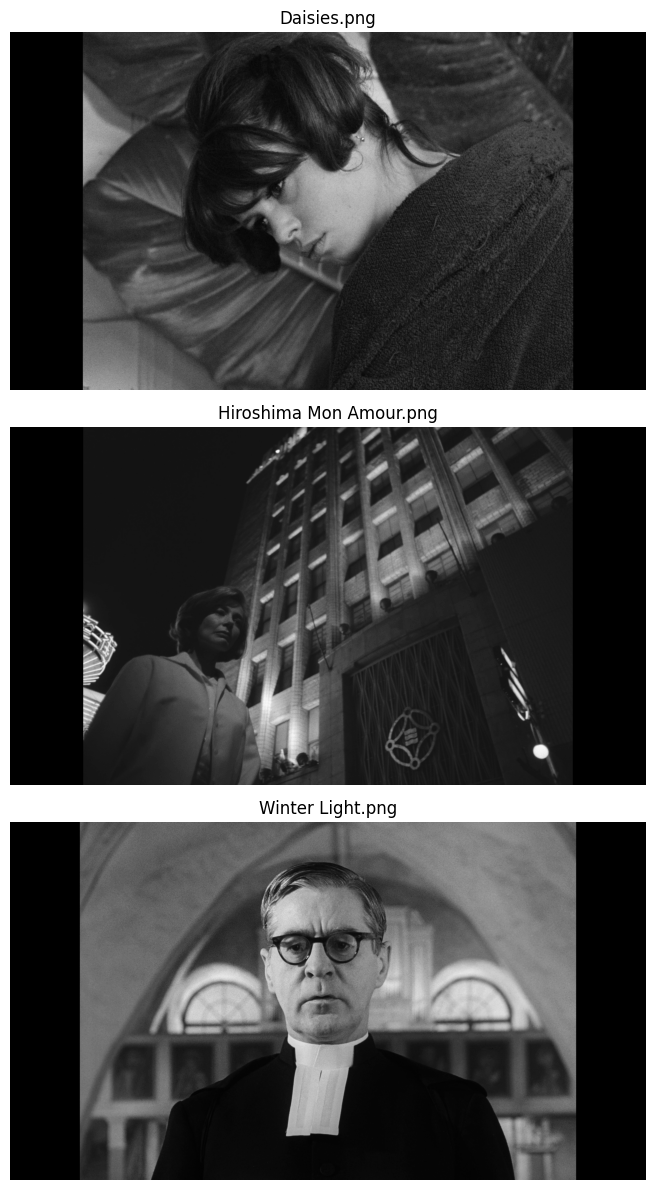

In [121]:
image_paths = ['Daisies.png', 'Hiroshima Mon Amour.png', 'Winter Light.png']

def load_images(path_to_images):  
    """  
    Loads images from the specified paths and converts them to grayscale.  
    
    Parameters:  
    path_to_images: List of image paths to load  

    Returns:  
    image_arrays: List of numpy arrays representing the grayscale images  
    """  
    image_arrays = []  

    for path in path_to_images:  
        img = Image.open(path).convert('L')  # Convert to grayscale  
        img_array = np.array(img)  
        image_arrays.append(img_array)  

    return image_arrays  

# Plotting function  
def plot_images(images, titles):  
    """  
    Plots a list of images with their titles.  

    Parameters:  
    images: List of numpy arrays representing the images  
    titles: List of titles for each image  
    """  
    plt.figure(figsize=(8, 12))  # Update size to be taller  

    for i, img in enumerate(images):  
        plt.subplot(len(images), 1, i + 1)  # Change to (len(images), 1, i + 1)  
        plt.imshow(img, cmap='gray')  
        plt.title(titles[i])  
        plt.axis('off')  # Hide axes  

    plt.tight_layout()  
    plt.show()  

# Load and plot the images  
loaded_images = load_images(image_paths)  
plot_images(loaded_images, image_paths)

**Reconstruction of Image**

In order to compress images, we need to use fewer number of singular values in $Σ$. Write a function that reconstructs the input array given the percentage of singular values to keep.

In [122]:
def reconstruct_image(img, SVD_func, sp):
    """
    Reconstructs an image using Singular Value Decomposition (SVD).
    
    Parameters:
    img: Numpy array representing the input image
    SVD_func: Function to compute the SVD of the image
    sp: Percentage of singular values to keep (between 0 and 1)

    Returns:
    Reconstructed image as a numpy array
    """
    # Step 1: Calculate SVD of the input image  
    U, S, Vt = SVD_func(img)  

    # Step 2: Calculate the number of singular values to retain   
    k = int(np.floor(sp * len(S)))  # Ensure k is an integer  

    # Step 3: Reduced U and diagonal S matrix construction  
    U_reduced = U[:, :k]  # First k columns of U  
    S_reduced = S[:k]  # First k singular values  

    # Create diagonal matrix for significant singular values  
    D = np.zeros((k, k))  
    for i in range(k):  
        D[i, i] = S_reduced[i][i]  # Fill diagonal with the singular values  

    # Step 4: Retain only the top k rows of Vt  
    Vt_reduced = Vt[:, :k]  # First k col of Vt  

    # Step 5: Reconstructing the image using the reduced matrices  
    reconstructed_img = U_reduced @ D @ Vt_reduced.T  # Perform matrix multiplication  

    return reconstructed_img 


Now reconstruct all the loaded images with ```sp = 0.04 ``` and plot them alongside the original images.

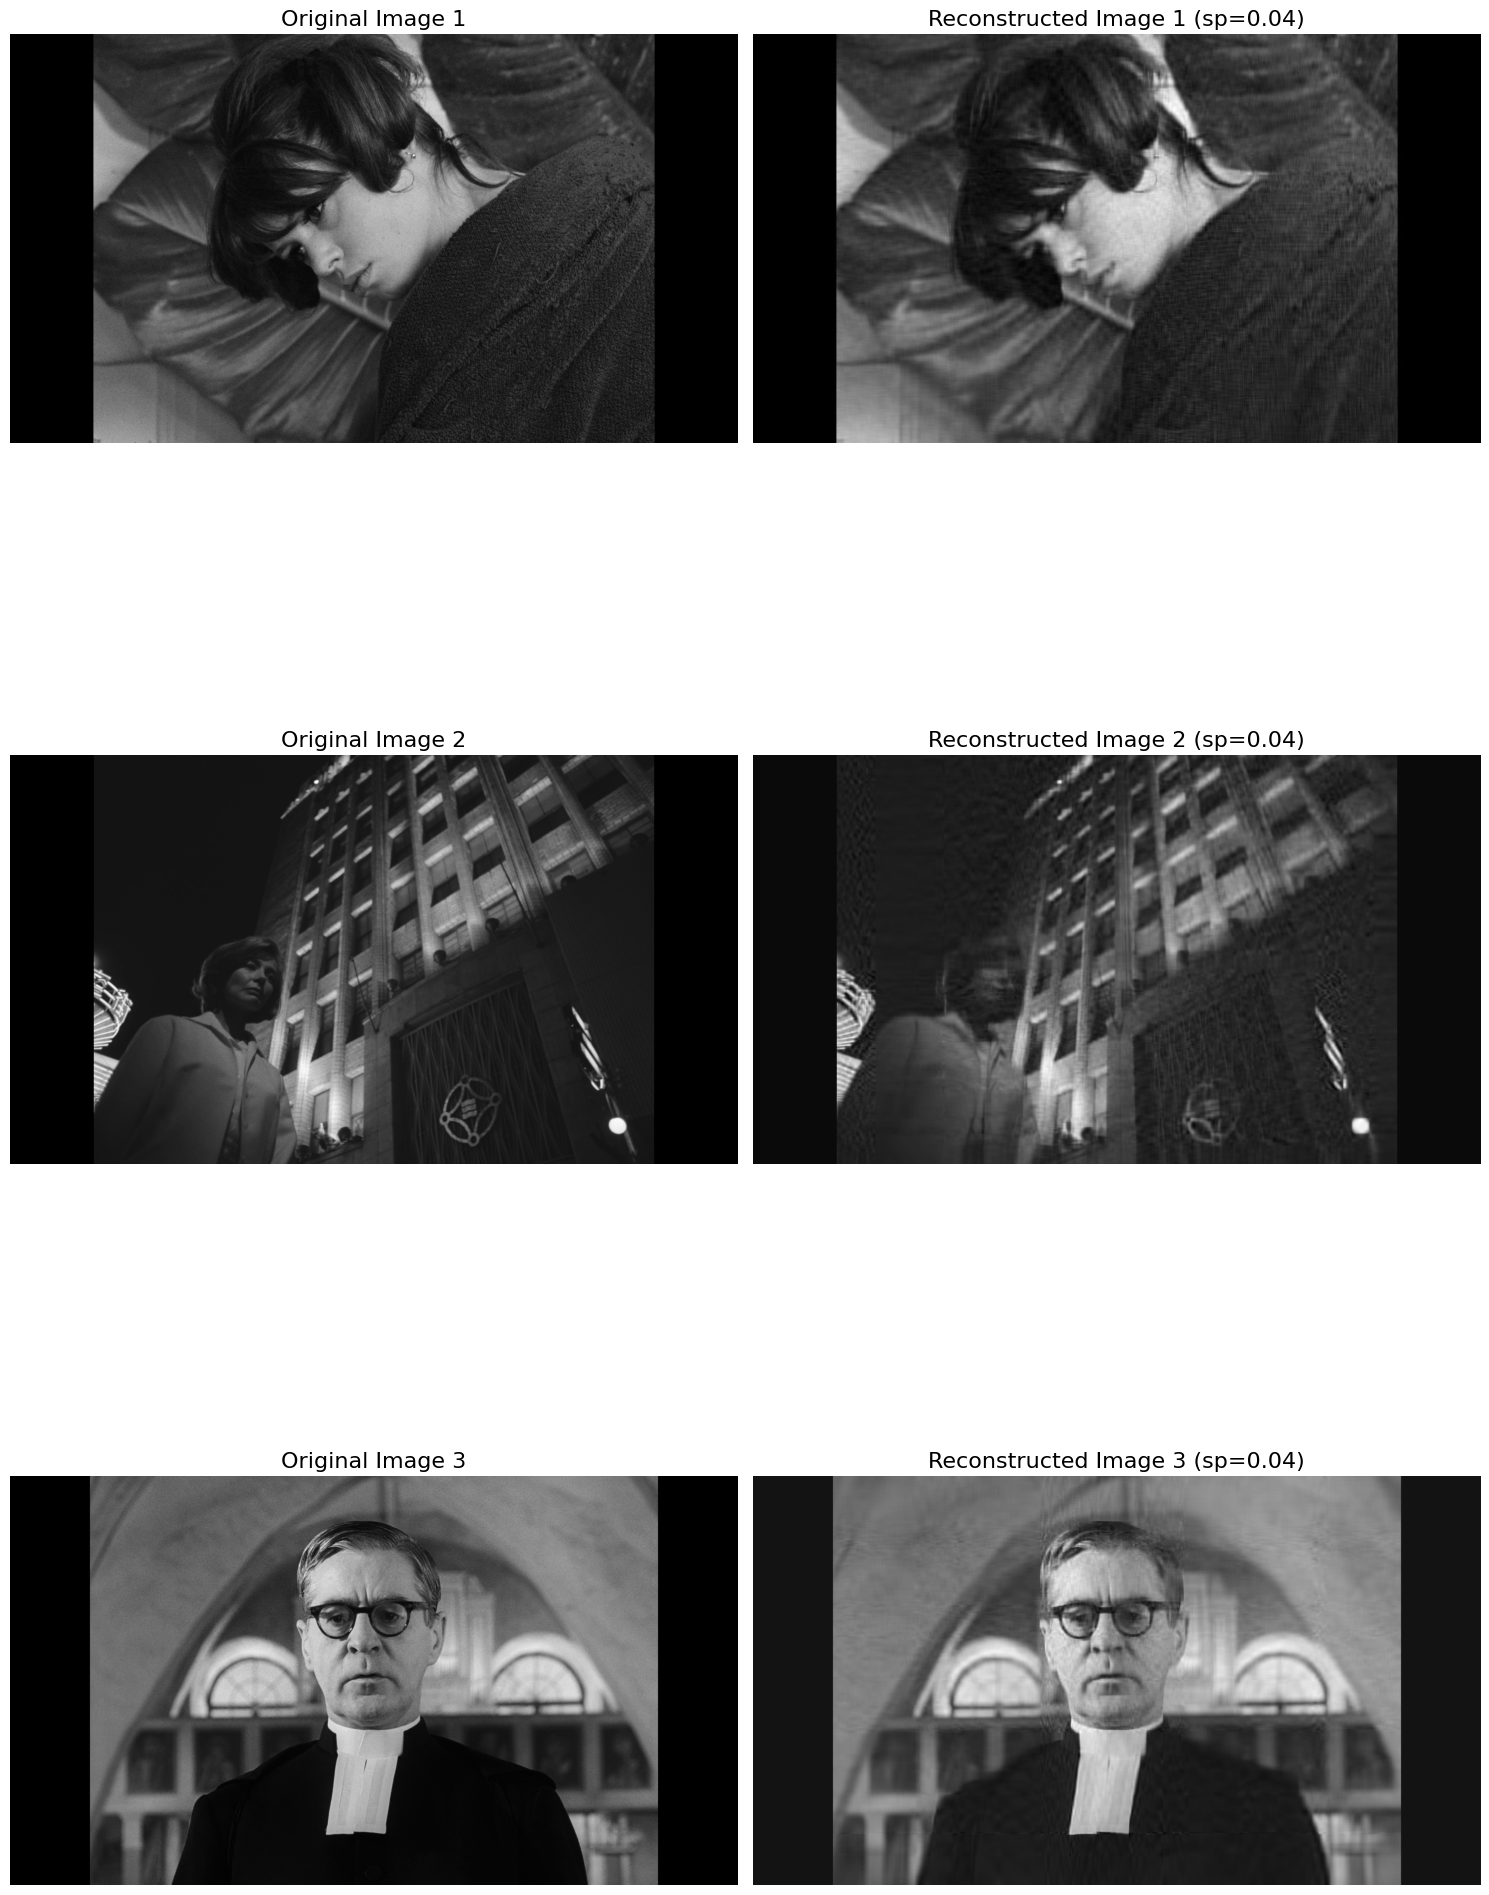

In [123]:
# Reconstruct images using SVD  
r_image = np.array([reconstruct_image(im, get_svd, 0.04) for im in loaded_images])  

# Plot the original and reconstructed images  
fig, axes = plt.subplots(len(loaded_images), 2, figsize=(15, 8 * len(loaded_images)))  

for i, (orig, recon) in enumerate(zip(loaded_images, r_image)):  
    axes[i, 0].imshow(orig, cmap="gray")  # Original image  
    axes[i, 0].set_title(f"Original Image {i + 1}", fontsize=16)  
    axes[i, 0].axis("off")  # Hide axis  

    axes[i, 1].imshow(recon, cmap="gray")  # Reconstructed image  
    axes[i, 1].set_title(f"Reconstructed Image {i + 1} (sp=0.04)", fontsize=16)  
    axes[i, 1].axis("off")  # Hide axis  

plt.tight_layout()  
plt.show()  

You can save the reconstructed images and compare their sizes with the respective original image.

In [124]:
for i in range(len(r_image)):
  plt.imsave(image_paths[i].split('.')[0] + '_compressed.png', r_image[i], cmap='gray')

Choose one of the images and plot the original image and the reconstructed images with ``` sp = [0.2, 0.1, 0.05, 0.03, 0.01] ```.

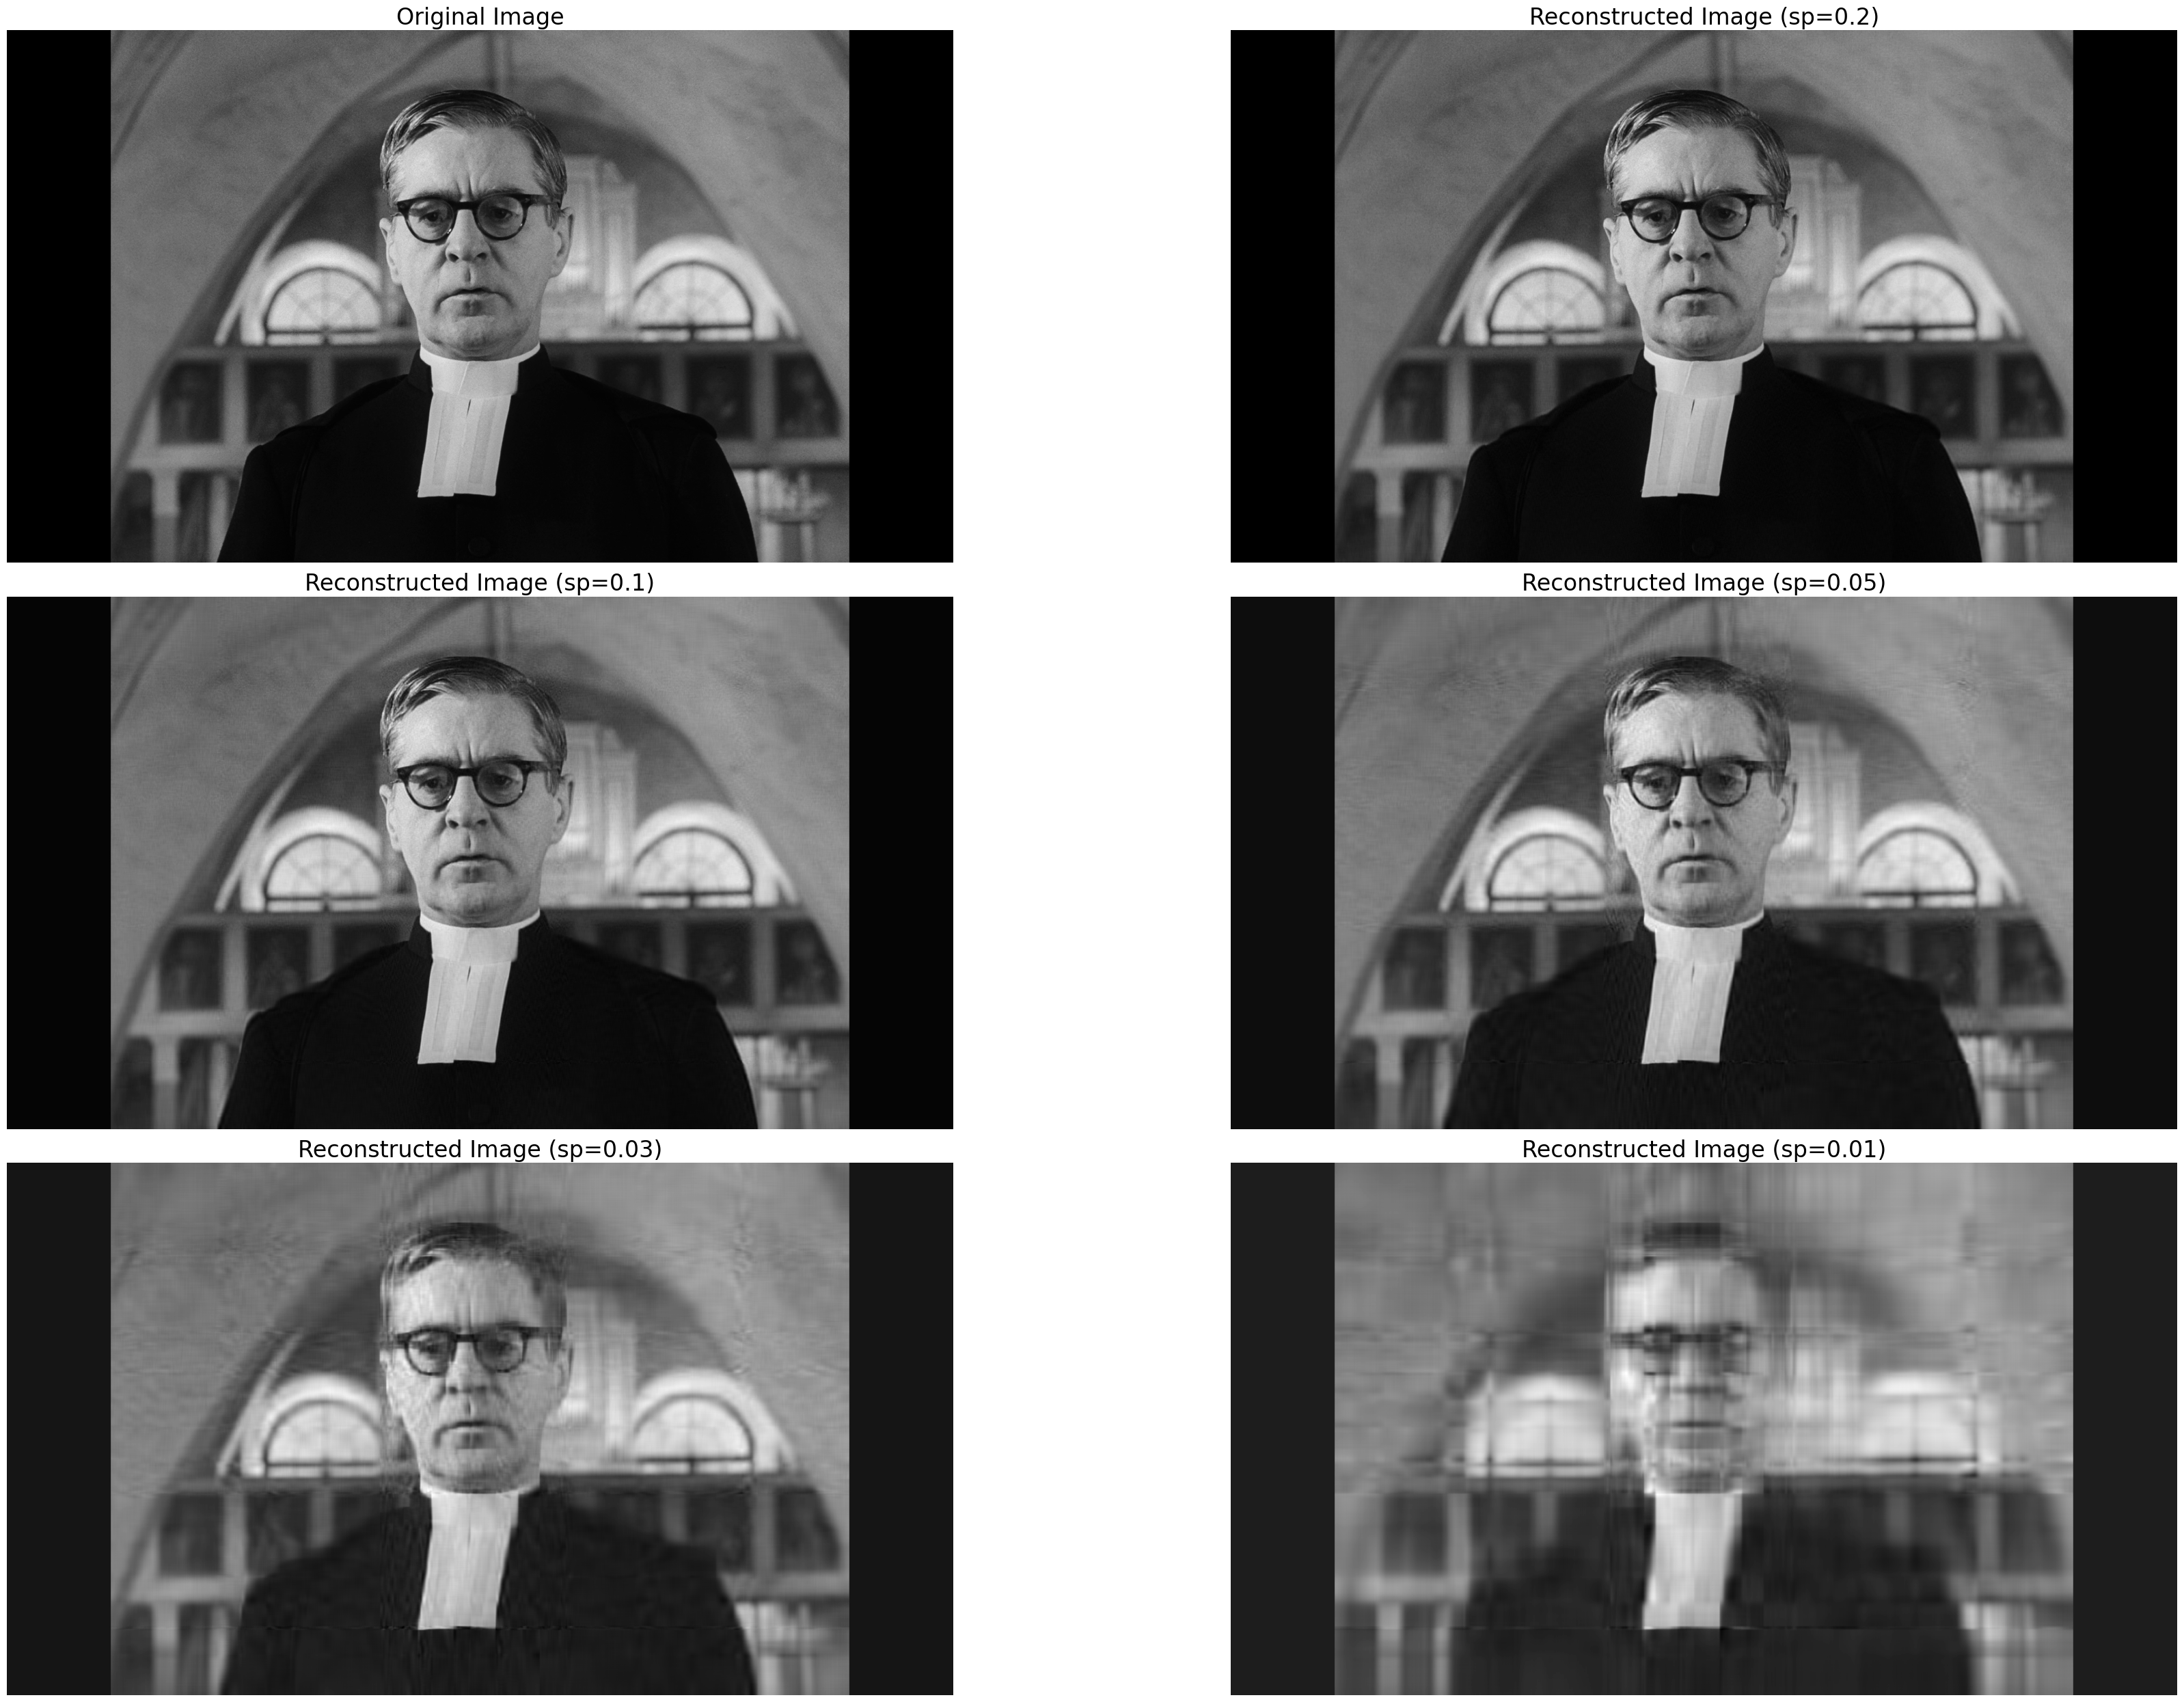

In [125]:
sps = [0.2, 0.1, 0.05, 0.03, 0.01]
re_image = np.array([reconstruct_image(loaded_images[-1], get_svd, sp = s) for s in sps])

fig, axes = plt.subplots(3, 2, figsize=(40, 25))

# TODO: Plot the original image and the reconstructed images with different number of singular values
# Plot the original image  
axes[0, 0].imshow(loaded_images[-1], cmap="gray")  
axes[0, 0].set_title("Original Image", fontsize=24)  
axes[0, 0].axis("off")  

# Flatten axes for easier indexing if needed  
axes_flat = axes.flatten()  

# Plot the reconstructed images with different percentages of singular values  
for i, sp in enumerate(sps):  
    ax = axes_flat[i + 1]  # Start from the second subplot  
    ax.imshow(re_image[i], cmap="gray")  # Reconstructed images  
    ax.set_title(f"Reconstructed Image (sp={sp})", fontsize=24)  
    ax.axis("off")  

plt.tight_layout()  
plt.show()  

# **Latent Semantic Analysis**

In order to demonstrate another application of SVD, we use Latent Semantic Indexing/Analysis as a technique to find out how different words are related to each other.

**Environment Setup**

In [126]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.sparse.linalg import svds

**Downloading the Dataset**

For this task we will use ```fetch_20newsgroups``` dataset from ```scikit-learn``` package. This dataset contains about 20000 news documents categorized into 20 topics. We will be using 5 of them for convenience.

In [127]:
categories =  ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'sci.electronics', 'rec.sport.hockey']
random_state = 42
doc_text = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=random_state).data

**Data Transformation**

Since it is not possible to work directly with words, we need to transform the text into numerical data. The tool that will be used is ```TFidfVectorizer``` from scikit-learn that takes both occurrence frequency and importance into account and thus provides better results by focusing on informative words. Create a vectorizer of this type and transform the documents. Use 2000 features to increase efficiency.

In [128]:
max_features = 2000
stop_words = 'english'
# TODO: Initialize a TfidfVectorizer  
vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')  

# TODO: Use the vectorizer to compute the IDF values on the documents and convert it to TF-IDF feature matrix  
tfidf_matrix = vectorizer.fit_transform(doc_text)  

# Convert the TF-IDF matrix to an array (optional)  

**Reconstruction**

Now apply SVD on matrix ```C``` and then reconstruct it using ```k = 5``` singular values. You will have to change the data type to ```np.float32``` first.

Notice: As you have probably realized, the manually implemented SVD does not follow an efficient algorithm for the decomposition. Since the matrix ```X``` is much larger than the matrices from the grayscale images, we will be using ```svds``` from ```scipy.sparse.linalg``` that can decompose sparse matrices much faster.

In [129]:
k = 5

# TODO: Convert the matrix datatype to np.float32
X = tfidf_matrix.astype(np.float32)

# TODO: Perform SVD on the matrix using svds and the value of k and print the shape of V^T
U, sigma, Vt = svds(X, k=k)  

# Print the shape of V^T  
print("Shape of V^T:", Vt.shape)  

# Optional: To reconstruct the matrix using U, sigma, and Vt  
# Create a diagonal matrix for sigma  
sigma_matrix = np.diag(sigma)  

# Reconstruct the matrix using the three matrices  
reconstructed_X = np.dot(np.dot(U, sigma_matrix), Vt)  

# Print the shape of the reconstructed matrix  
print("Shape of the reconstructed matrix:", reconstructed_X.shape)  

Shape of V^T: (5, 2000)
Shape of the reconstructed matrix: (2970, 2000)


Now extract the words from the vectorizer and save it. Then use the previously imported ```cosine_similarity``` to measure how related different words are. You can also see what feature names have been kept in the vectorizer.

In [130]:
# TODO: get the feature names from the vectorizer and save it in a document
# Extract the feature names from the vectorizer  
terms = vectorizer.get_feature_names_out()  

# Save the feature names to a document  

print("Feature names saved to feature_names.txt")

def word_similarity(word1, word2, terms, Vt):
    """
    Calculates the cosine similarity between two words based on their vector representations.
    
    Parameters:
    word1: First word for similarity comparison
    word2: Second word for similarity comparison
    terms: List of words corresponding to the feature names from the TF-IDF Vectorizer
    Vt: Transposed V matrix from the SVD of the TF-IDF matrix

    Returns:
    similarity: Cosine similarity between the two words (float) or None if one or both words are not found
    """
    
       
    # Step 1: Check if both words are in the terms list  
    if word1 not in terms or word2 not in terms:  
        return None  # Return None if either word is not found  

    # Step 2: Get the indices of the words in the terms list  
    index1 = np.where(terms == word1)[0]  
    index2 = np.where(terms == word2)[0]  

    # Check if both words were found in the terms list  
    if index1.size == 0 or index2.size == 0:  
        return None  

    # Step 3: Safely retrieve the vectors for both words from the Vt matrix  
    vector1 = Vt[:, index1[0]].reshape(1, -1)  # Use first index since index1 should return a single result  
    vector2 = Vt[:, index2[0]].reshape(1, -1)  

    # Step 4: Calculate the cosine similarity between the two vectors  
    similarity = cosine_similarity(vector1, vector2)[0][0]  

    return similarity   

Feature names saved to feature_names.txt


**Test Performance**

Output the similarity between the two words in each row and check if the measures are sensible.

In [131]:
word_mat = [['grade', 'average'],
            ['grade', 'horse'],
            ['horse', 'ride'],
            ['horse', 'programs'],
            ['programs', 'versions'],
            ['programs', 'toronto'],
            ['hockey', 'ice'],
            ['hockey', 'linux'],
            ['linux', 'windows'],
            ['linux', 'week']]

# TODO: print the similarity of each pair of words
# Assuming words have been defined and Vt is available  
similarities = {}  # Dictionary to store similarity results  

# Iterate over each pair of words in word_mat  
for pair in word_mat:  
    word1, word2 = pair  
    similarity_score = word_similarity(word1, word2, terms, Vt)  
    similarities[(word1, word2)] = similarity_score  # Store the result  

# Print the similarity for each pair  
for (word1, word2), score in similarities.items():  
    if score is not None:  # Check if the similarity could be calculated  
        print(f"Cosine similarity between '{word1}' and '{word2}': {score:.4f}")  
    else:  
        print(f"One or both words '{word1}' and '{word2}' not found in the vocabulary.")

Cosine similarity between 'grade' and 'average': 0.9234
Cosine similarity between 'grade' and 'horse': -0.3944
Cosine similarity between 'horse' and 'ride': 0.9742
Cosine similarity between 'horse' and 'programs': -0.4775
Cosine similarity between 'programs' and 'versions': 0.9587
Cosine similarity between 'programs' and 'toronto': -0.2397
Cosine similarity between 'hockey' and 'ice': 0.9697
Cosine similarity between 'hockey' and 'linux': -0.1451
Cosine similarity between 'linux' and 'windows': 0.9678
Cosine similarity between 'linux' and 'week': 0.0701


### **PCA, Alternative Method**

Principal Component Analysis is another method that can be used for Latent Semantic Analysis. PCA is another dimensionality reduction technique commonly used in machine learning and statistical tasks to transform the data into a simpler space with new variables called principal components where it is easier to analyze data. PCA tries to cause the least loss of information in this process. Before performing PCA, the matrix must be in <b>mean-deviation form</b>. Suppose $[X_{1}, ..., X_{N}]$ is a $p \times N$ matrix of observations (a matrix in which the columns are different samples of data and the rows contain different pieces of information about that sample). The sample mean of $X$ is given by
$$
  M = \frac{1}{N}(X_{1} + ... + X_{N}).
$$
If $\hat{X}_{k}$ is defined as $\hat{X}_{k} = X_{k} - M$ then
$$
B = [\hat{X}_{1}, ..., \hat{X}_{N}]
$$
is in mean-deviation form.

The PCA objective is to find an orthogonal $p \times p$ matrix $P$ that determines the change of variable, $X = PY$ with the property that the new variables in $Y = [y_{1}, ..., y_{n}]^T$ are uncorrelated and are arranged in order of decreasing variance. These variables are then used to reduce the dimensionality of the input.

You can visit this [link](https://www.youtube.com/watch?v=FgakZw6K1QQ) for a better understanding of what PCA is and how it works.

First thing needed to be done is to create a dense array from the transformed matrix ```X```, since PCA works with dense arrays. Then use ```PCA``` on the dense array with 10 principal components. And finally transform the transpose of output.

In [134]:

from sklearn.decomposition import PCA  
np.random.seed(42)  # You can use any integer here  
# Assuming X is your transformed matrix (e.g., from TF-IDF or SVD)  
# Step 1: Convert the matrix into a dense array  
dense_X = X.toarray()  # If X is a sparse matrix, use toarray() method  

# Step 2: Initialize PCA, keeping 10 components  
pca = PCA(n_components=10)  

# Step 3: Fit the PCA model with the dense matrix and reduce dimensionality  
pca_output = pca.fit_transform(dense_X.T)  

# Print the shape of the output  
print("Shape of PCA output:", pca_output.shape)  

Shape of PCA output: (2000, 10)


As the last step, use the same array of words (```word_mat```) to observe the performance of PCA.

In [135]:
# TODO: Print the similarity measure using the new matrix
def word_similarity_pca(word1, word2, original_terms, pca_output):  
    """  
    Calculates the cosine similarity between two words using PCA transformed output.  
    
    Parameters:  
    word1: First word for similarity comparison  
    word2: Second word for similarity comparison  
    original_terms: List of words corresponding to the feature names from the original matrix  
    pca_output: The PCA-transformed matrix  

    Returns:  
    similarity: Cosine similarity between the two words (float) or None if one or both words are not found  
    """  
    # Step 1: Check if both words are in the original terms list  
    if word1 not in original_terms or word2 not in original_terms:  
        return None  # Return None if either word is not found  

    # Step 2: Get the indices of the words in the original terms list  
    index1 = np.where(original_terms == word1)[0]  
    index2 = np.where(original_terms == word2)[0]  

    # Check if both words were found in the terms list  
    if index1.size == 0 or index2.size == 0:  
        return None  

    # Step 3: Retrieve the vectors for both words from the PCA output  
    vector1 = pca_output[index1[0]]  # Use the first index as it should return a single result  
    vector2 = pca_output[index2[0]]  

    # Step 4: Calculate the cosine similarity between the two vectors  
    similarity = cosine_similarity(vector1.reshape(1, -1), vector2.reshape(1, -1))[0][0]  

    return similarity  

# Now, calculate the similarities based on the PCA output  
similarities_pca = {}  # Dictionary to store similarity results  

# Iterate over each pair of words in word_mat  
for pair in word_mat:  
    word1, word2 = pair  
    similarity_score = word_similarity_pca(word1, word2, terms, pca_output)  
    similarities_pca[(word1, word2)] = similarity_score  # Store the result  

# Print the similarity for each pair  
for (word1, word2), score in similarities_pca.items():  
    if score is not None:  # Check if the similarit
        # y could be calculated  
        print(f"Cosine similarity between '{word1}' and '{word2}' using PCA: {score:.4f}")  
    else:  
        print(f"One or both words '{word1}' and '{word2}' not found in the vocabulary.")  

Cosine similarity between 'grade' and 'average' using PCA: 0.2284
Cosine similarity between 'grade' and 'horse' using PCA: -0.0151
Cosine similarity between 'horse' and 'ride' using PCA: 0.3049
Cosine similarity between 'horse' and 'programs' using PCA: -0.2531
Cosine similarity between 'programs' and 'versions' using PCA: 0.5334
Cosine similarity between 'programs' and 'toronto' using PCA: -0.2827
Cosine similarity between 'hockey' and 'ice' using PCA: 0.9092
Cosine similarity between 'hockey' and 'linux' using PCA: -0.4519
Cosine similarity between 'linux' and 'windows' using PCA: 0.7524
Cosine similarity between 'linux' and 'week' using PCA: -0.2544


Compare the result of PCA and SVD for the LSA task based the similarity measure you used. Which one captures the connections between words better? Based on the sparse nature of term-document matrices, explain why this difference in performance appears despite the close relation of PCA and SVD.